## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [67]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_"
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_


In [68]:
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

#### Load cities

In [4]:
%cd "/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_"
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)
cities = cities.drop(columns = ['capital', 'admin_name'], axis = 1)

/home/mogan/Desktop/z_ada/ada-2020-project-milestone-p3-p3_


In [5]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,population,id,area
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,37977000.0,1392685764,2194.07
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,34540000.0,1360771077,7062.50
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,29617000.0,1356872604,1484.00
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,23355000.0,1356226629,4355.00
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,23088000.0,1608618140,1474.82


#### Load edges

In [6]:
%cd "/home/mogan/Desktop"
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

/home/mogan/Desktop


### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


In [7]:
cities = cities.drop(columns=['city_ascii', 'iso3', 'id'], axis=1)
cities.head()

,city,lat,lng,country,iso2,population,area
0,Tokyo,35.6897,139.6922,Japan,JP,37977000.0,2194.07
1,Jakarta,-6.2146,106.8451,Indonesia,ID,34540000.0,7062.50
2,Delhi,28.6600,77.2300,India,IN,29617000.0,1484.00
3,Mumbai,18.9667,72.8333,India,IN,23355000.0,4355.00
4,Manila,14.5958,120.9772,Philippines,PH,23088000.0,1474.82


In [8]:
# We had the impression that some US cities are missing in the cities data set, so we crawled another data set from wikipedia
# Wrangle us cities to fit to other cities
%cd "/home/mogan/Desktop"
us_cities = pd.read_csv("./data/us_cities.csv")
us_cities = us_cities.drop(columns=['2019rank', 'State[c]', '2010Census', 'Change', '2016 land area','2016 population density'])
us_cities = us_cities.rename(columns={'City':'city', '2019estimate':'population', '2016 land area.1':'area','2016 population density.1':'density' })
us_cities['population'] = us_cities['population'].str.replace(',','.')#.astype('float64')
us_cities['population'] = us_cities['population'].str.replace(r'\.', '').astype(float)
us_cities['city'] = us_cities['city'].str.replace(r'\[\w+\]', '')
us_cities['area'] = us_cities['area'].str.replace(r'\s\D+\d', '')
us_cities['area'] = us_cities['area'].str.replace(',','').astype(float)
us_cities['density'] = us_cities['density'].str.replace(r'/\D+\d', '')
us_cities['density'] = us_cities['density'].str.replace(',','').astype(float)
us_cities['Location'] = us_cities['Location'].str.split(r'/', expand = True)[1]
us_cities[['lat', 'lng']] = us_cities['Location'].str.split(r'\s', expand = True)[[1,2]]
us_cities = us_cities.drop(columns=['Location'], axis=1)
us_cities['lat'] = us_cities['lat'].str.replace('°N','').str.replace('\ufeff','').astype(float)
us_cities['lng'] = us_cities['lng'].str.replace('°W','').str.replace('\ufeff','').astype(float)
us_cities['iso2'] = 'US'
us_cities['country'] = 'United States'
us_cities

/home/mogan/Desktop


,city,population,area,density,lat,lng,iso2,country
0,New York City,8336817.0,780.9,10933.0,40.6635,73.9387,US,United States
1,Los Angeles,3979576.0,1213.9,3276.0,34.0194,118.4108,US,United States
2,Chicago,2693976.0,588.7,4600.0,41.8376,87.6818,US,United States
3,Houston,2320268.0,1651.1,1395.0,29.7866,95.3909,US,United States
4,Phoenix,1680992.0,1340.6,1200.0,33.5722,112.0901,US,United States
...,...,...,...,...,...,...,...,...
312,San Angelo,101004.0,155.1,649.0,31.4411,100.4505,US,United States
313,Vacaville,100670.0,75.1,1332.0,38.3539,121.9728,US,United States
314,Clinton,100471.0,72.8,1380.0,42.5903,82.9170,US,United States
315,Bend,100421.0,85.7,1171.0,44.0500,121.3000,US,United States


In [9]:
# 0. Estimate the missing areas for cities
n_cities = cities[cities['area'].isna()]
n_cities = n_cities[n_cities['population'] > 50000]

# Cannot predict for unknown population
n_cities = n_cities[~n_cities['population'].isnull()]

# Drop missing values for prediction
cities = cities[cities['population'] > 50000]
cities = cities[~cities['area'].isnull()]

In [10]:
# 1. Construct a linear model to estimate the missing areas
X = cities['population'].values.reshape(-1, 1)
y = cities['area'].values
reg = LinearRegression().fit(X, y)

# Predict the missing areas
pred_area = reg.predict(n_cities['population'].values.reshape(-1, 1))
n_cities['area'] = pred_area

# Merge city data
cities = cities.append(n_cities)

# 2. Calculate population density again for all data
cities['density'] = cities['population'] / cities['area']

In [11]:
# merge the city data
cities = cities.append(us_cities)
cities = cities[cities['population'] > 50000]

In [12]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

In [13]:
cities

,city,lat,lng,country,iso2,population,area,density,radius
0,Tokyo,35.6897,139.6922,Japan,JP,37977000.0,2194.07,17308.928156,26.427148
1,Jakarta,-6.2146,106.8451,Indonesia,ID,34540000.0,7062.50,4890.619469,47.413749
2,Delhi,28.6600,77.2300,India,IN,29617000.0,1484.00,19957.547170,21.734118
3,Mumbai,18.9667,72.8333,India,IN,23355000.0,4355.00,5362.801378,37.232238
4,Manila,14.5958,120.9772,Philippines,PH,23088000.0,1474.82,15654.791771,21.666790
...,...,...,...,...,...,...,...,...,...
312,San Angelo,31.4411,100.4505,United States,US,101004.0,155.10,649.000000,7.026369
313,Vacaville,38.3539,121.9728,United States,US,100670.0,75.10,1332.000000,4.889281
314,Clinton,42.5903,82.9170,United States,US,100471.0,72.80,1380.000000,4.813830
315,Bend,44.0500,121.3000,United States,US,100421.0,85.70,1171.000000,5.222945


In [14]:
# 4. Drop cities with # inhabitants < 50.000 and population density < 1500
cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]
cities = cities.drop_duplicates()

In [15]:
# Save cities dataframe
cities.to_pickle("cities.pickle")

### Does user live in rural or urban area?

  for each country:
  
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes



In [77]:
# Take a subset for now
B_homes[(B_homes['country'] == 'US')]
G_homes[(G_homes['country'] == 'US')]

B_homes = B_homes.sample(4000, random_state=1)
G_homes = G_homes.sample(4000, random_state=1)

In [17]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')

In [18]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)

In [19]:
B_merge.head()

,longitude,latitude,country_x,user,city,lat,lng,country_y,iso2,population,area,density,radius,distance_to_city
0,-116.203451,43.6135,US,18790,Los Angeles,34.1139,-118.4068,United States,US,12750807.0,4850.00,2629.032371,39.291258,1071.665474
1,-116.203451,43.6135,US,18790,Dallas,32.7936,-96.7662,United States,US,5743938.0,1407.20,4081.820637,21.164255,2074.975030
2,-116.203451,43.6135,US,18790,Philadelphia,40.0077,-75.1339,United States,US,5649300.0,142.70,39588.647512,6.739645,3401.119974
3,-116.203451,43.6135,US,18790,Houston,29.7863,-95.3889,United States,US,5464251.0,1062.00,5145.245763,18.386003,2399.046326
4,-116.203451,43.6135,US,18790,San Diego,32.8312,-117.1225,United States,US,3220118.0,372.42,8646.469040,10.887836,1199.531108


In [20]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [21]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [22]:
B_homes.head()
G_homes.head()

,longitude,latitude,country,user,lives_urban
user_id,,,,,
76280,-117.886019,33.801853,US,76280,False
186772,17.227778,62.410301,SE,186772,False
55115,-121.305415,44.064791,US,55115,False
28361,-86.806300,33.482397,US,28361,True
132303,11.984316,57.693889,SE,132303,False


In [23]:
# Save intermediate results
# Save home locations
B_merge.to_pickle("B_merge_.pickle")
G_merge.to_pickle("G_merge_.pickle")

### Calculate # friends per user, group by rural/city and compare amount of friends


In [24]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [25]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [26]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
18790,-116.203451,43.613500,US,18790,True,1
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10


### Compare amount of friends for urban/ rural users

In [27]:
B_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,2729.0,7.913155,27.909445,1.0,1.0,3.0,7.0,854.0
True,1178.0,10.084041,35.983696,1.0,1.0,3.0,8.0,1055.0


In [28]:
G_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,2723.0,12.518546,39.994672,1.0,2.0,5.0,11.0,941.0
True,1105.0,13.542986,45.154728,1.0,2.0,4.0,10.0,942.0


/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/mogan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


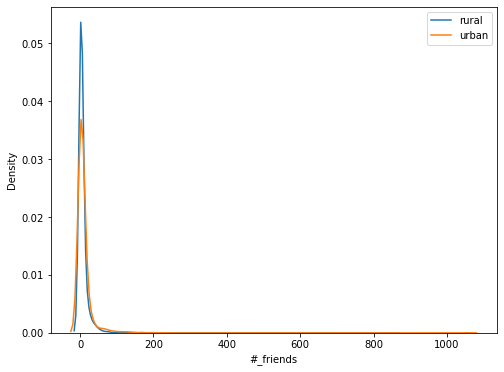

In [29]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural', hist=False)
sns.distplot(B_urban['#_friends'], label='urban', hist=False)
plt.legend();

In [54]:
G_homes

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
76280,-117.886019,33.801853,US,76280,False,1
186772,17.227778,62.410301,SE,186772,False,2
55115,-121.305415,44.064791,US,55115,False,11
28361,-86.806300,33.482397,US,28361,True,47
132303,11.984316,57.693889,SE,132303,False,5
...,...,...,...,...,...,...
112421,14.534028,61.006525,SE,112421,False,3
121558,-84.211276,40.037755,US,121558,False,3
146310,11.926609,57.657156,SE,146310,False,2


<Figure size 576x432 with 0 Axes>

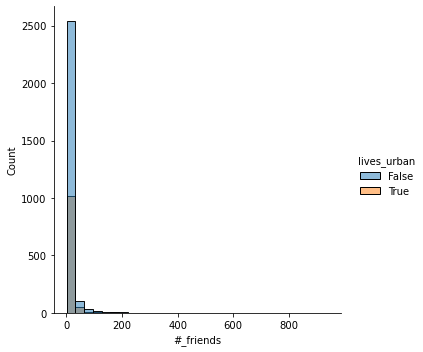

In [62]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.displot(data = G_homes, x = '#_friends', hue='lives_urban', kind="hist", bins = 30)
#sns.displot(G_urban['#_friends'], label='urban', kind="hist")
#plt.legend();

### Statistical Test to investigate significant effect

We will perform a poisson-test to inspect whether the two samples stem from the same possion distribution. We assume $\alpha = 0.05$.

Check assumptions:
1. Underlying distribution is a poisson
2. estimate the four rates, $\lambda_{bk-urban}, \lambda_{bk-rural},\lambda_{gw-urban},\lambda_{gw-rural}$

All four distributions seems to be a bit more skewed than expected for a poisson distribution.


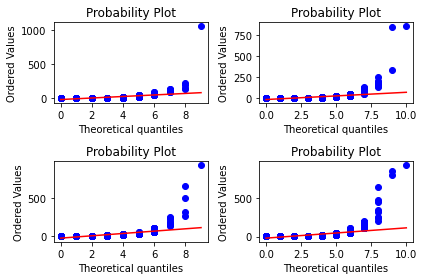

In [31]:
# 2. Inspect the distribution of the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

data = B_urban['#_friends']
stats.probplot(B_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax1)
stats.probplot(B_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax2)
stats.probplot(G_urban['#_friends'], dist='poisson', sparams=(2.5,), plot=ax3)
stats.probplot(G_rural['#_friends'], dist='poisson', sparams=(2.5,), plot=ax4)
fig.tight_layout()

print("All four distributions seems to be a bit more skewed than expected for a poisson distribution.")

In [32]:
sample1_k, sample1_n = B_urban['#_friends'].mean(), len(B_urban)
sample2_k, sample2_n = B_rural['#_friends'].mean(), len(B_rural)
poiss_p_1 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_1,6)}.")

Brighkite data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.047074.


In [33]:
sample1_k, sample1_n = G_urban['#_friends'].mean(), len(G_urban)
sample2_k, sample2_n = G_rural['#_friends'].mean(), len(G_rural)
poiss_p_2 = poisson_etest(sample1_k, sample2_k, sample1_n, sample2_n)
print(f"Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of {round(poiss_p_2,6)}.")

Gowalla data does not come from the same poisson distribution given alpha = 0.05, and a p-value of 0.042888.


TODO 
Do directional hypothesis

## OLD

In [34]:
# 1. Check for equal variances:
# The Levene test tests the null hypothesis that all input samples are from populations with equal variances.

#_, p1 = levene(B_urban['#_friends'], B_rural['#_friends'])
#_, p2 = levene(G_urban['#_friends'], G_rural['#_friends'])

#print(" p-value Brightkite:", p1, "\n", "p-value Gowalla:", p2, "\n")
#print("We reject the null hypothesis that all input samples are from populations with equal variance for the Brightkite data, but not for the Gowalla data.")

In [35]:
stats.ttest_ind(B_urban['#_friends'],B_rural['#_friends'], equal_var = False)

Ttest_indResult(statistic=1.8449063677581616, pvalue=0.065214003422082861)

In [36]:
##  Perform the t-test
stats.ttest_ind(G_urban['#_friends'],G_rural['#_friends'], equal_var = True)

Ttest_indResult(statistic=0.69125864711956675, pvalue=0.48944495335123128)